In [2]:
import pandas as pd

# Load the dataset again and display the first few rows
churn_dataset = pd.read_csv('customer_churn_large_dataset.csv')
churn_dataset.head()


CustomerID        Name  Age  Gender     Location  \
0           1  Customer_1   63    Male  Los Angeles   
1           2  Customer_2   62  Female     New York   
2           3  Customer_3   24  Female  Los Angeles   
3           4  Customer_4   36  Female        Miami   
4           5  Customer_5   46  Female        Miami   

   Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
0                          17         73.36             236      0  
1                           1         48.76             172      0  
2                           5         85.47             460      0  
3                           3         97.94             297      1  
4                          19         58.14             266      0

###
CustomerID: Unique identifier for the customer.
Name: Name of the customer.
Age: Age of the customer.
Gender: Gender of the customer.
Location: Location or city of the customer.
Subscription_Length_Months: Duration of the customer's subscription in months.
Monthly_Bill: Amount billed to the customer monthly.
Total_Usage_GB: Total data usage by the customer in GB.
Churn: Binary indicator representing whether a customer churned (1) or not (0).

In [3]:
# 1. Handle Missing Data

# Check for missing values in each column
missing_values = churn_dataset.isnull().sum()

# Impute missing values
for column in churn_dataset.columns:
    if churn_dataset[column].dtype == 'object':  # Categorical data
        churn_dataset[column].fillna(churn_dataset[column].mode()[0], inplace=True)
    else:  # Numerical data
        churn_dataset[column].fillna(churn_dataset[column].median(), inplace=True)

# Confirm that missing values have been handled
missing_values_after = churn_dataset.isnull().sum()

missing_values, missing_values_after

(CustomerID                    0
 Name                          0
 Age                           0
 Gender                        0
 Location                      0
 Subscription_Length_Months    0
 Monthly_Bill                  0
 Total_Usage_GB                0
 Churn                         0
 dtype: int64,
 CustomerID                    0
 Name                          0
 Age                           0
 Gender                        0
 Location                      0
 Subscription_Length_Months    0
 Monthly_Bill                  0
 Total_Usage_GB                0
 Churn                         0
 dtype: int64)

In [4]:
# 2. Handle Outliers using the IQR method

numerical_columns = churn_dataset.select_dtypes(include=['float64', 'int64']).columns

for column in numerical_columns:
    Q1 = churn_dataset[column].quantile(0.25)
    Q3 = churn_dataset[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    churn_dataset[column] = churn_dataset[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)

# Display the first few rows after handling outliers
churn_dataset.head()

CustomerID        Name  Age  Gender     Location  \
0           1  Customer_1   63    Male  Los Angeles   
1           2  Customer_2   62  Female     New York   
2           3  Customer_3   24  Female  Los Angeles   
3           4  Customer_4   36  Female        Miami   
4           5  Customer_5   46  Female        Miami   

   Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
0                          17         73.36             236      0  
1                           1         48.76             172      0  
2                           5         85.47             460      0  
3                           3         97.94             297      1  
4                          19         58.14             266      0

In [5]:
# 3. Encode Categorical Variables using one-hot encoding

# Select categorical columns to be one-hot encoded
categorical_cols = churn_dataset.select_dtypes(include=['object']).columns.drop('Name')  # Excluding 'Name' as it's likely a unique identifier

# One-hot encode the categorical columns
churn_dataset_encoded = pd.get_dummies(churn_dataset, columns=categorical_cols, drop_first=True)

# Display the first few rows after encoding
churn_dataset_encoded.head()

CustomerID        Name  Age  Subscription_Length_Months  Monthly_Bill  \
0           1  Customer_1   63                          17         73.36   
1           2  Customer_2   62                           1         48.76   
2           3  Customer_3   24                           5         85.47   
3           4  Customer_4   36                           3         97.94   
4           5  Customer_5   46                          19         58.14   

   Total_Usage_GB  Churn  Gender_Male  Location_Houston  Location_Los Angeles  \
0             236      0            1                 0                     1   
1             172      0            0                 0                     0   
2             460      0            0                 0                     1   
3             297      1            0                 0                     0   
4             266      0            0                 0                     0   

   Location_Miami  Location_New York  
0               0                  0  
1               0                  1  
2               0                  0  
3               1                  0  
4               1                  0

In [6]:
from sklearn.model_selection import train_test_split

# Define predictors and target variable
X = churn_dataset_encoded.drop(columns=['CustomerID', 'Name', 'Churn'])
y = churn_dataset_encoded['Churn']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((80000, 9), (20000, 9), (80000,), (20000,))

### The data has been successfully split into training and testing sets:

Training data (predictors): 80,000 rows and 9 columns
Testing data (predictors): 20,000 rows and 9 columns
Training data (target variable): 80,000 rows
Testing data (target variable): 20,000 rows

Feature Engineering:
**bold text**
# Age Group: We can categorize ages into groups such as 'Young', 'Middle-aged', and 'Senior'.
Usage per Dollar: We can calculate the data usage (in GB) per dollar billed to measure efficiency or value for money.
Feature Scaling:
Many machine learning algorithms perform better when numerical input variables are scaled to a standard range. We'll use Min-Max scaling to scale our numerical features to the range [0, 1].

In [7]:
# 1. Feature Engineering

# Creating 'Age Group' feature
bins = [0, 30, 60, 100]  # Age bins
labels = ['Young', 'Middle-aged', 'Senior']
churn_dataset_encoded['Age Group'] = pd.cut(churn_dataset_encoded['Age'], bins=bins, labels=labels, right=False)

# Creating 'Usage per Dollar' feature
churn_dataset_encoded['Usage per Dollar'] = churn_dataset_encoded['Total_Usage_GB'] / churn_dataset_encoded['Monthly_Bill']

# One-hot encode the new 'Age Group' feature
churn_dataset_encoded = pd.get_dummies(churn_dataset_encoded, columns=['Age Group'], drop_first=True)

# Display the dataset after feature engineering
churn_dataset_encoded.head()


CustomerID        Name  Age  Subscription_Length_Months  Monthly_Bill  \
0           1  Customer_1   63                          17         73.36   
1           2  Customer_2   62                           1         48.76   
2           3  Customer_3   24                           5         85.47   
3           4  Customer_4   36                           3         97.94   
4           5  Customer_5   46                          19         58.14   

   Total_Usage_GB  Churn  Gender_Male  Location_Houston  Location_Los Angeles  \
0             236      0            1                 0                     1   
1             172      0            0                 0                     0   
2             460      0            0                 0                     1   
3             297      1            0                 0                     0   
4             266      0            0                 0                     0   

   Location_Miami  Location_New York  Usage per Dollar  Age Group_Middle-aged  \
0               0                  0          3.217012                      0   
1               0                  1          3.527482                      0   
2               0                  0          5.382005                      0   
3               1                  0          3.032469                      1   
4               1                  0          4.575163                      1   

   Age Group_Senior  
0                 1  
1                 1  
2                 0  
3                 0  
4                 0

### The new features "Age Group" and "Usage per Dollar" have been successfully added.

"Age Group" categorizes the ages into 'Young', 'Middle-aged', and 'Senior'.
"Usage per Dollar" represents the data usage efficiency or value for money for each customer.
Next, we'll apply feature scaling to the numerical features of our dataset using Min-Max scaling. This will scale our features to lie between 0 and 1, which can help improve the performance of many machine learning algorithms.

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Define the columns to scale. We'll scale only the numerical columns.
columns_to_scale = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB', 'Usage per Dollar']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Apply scaling to the relevant columns
churn_dataset_encoded[columns_to_scale] = scaler.fit_transform(churn_dataset_encoded[columns_to_scale])

# Display the dataset after scaling
churn_dataset_encoded.head()


CustomerID        Name       Age  Subscription_Length_Months  Monthly_Bill  \
0           1  Customer_1  0.865385                    0.695652      0.619429   
1           2  Customer_2  0.846154                    0.000000      0.268000   
2           3  Customer_3  0.115385                    0.173913      0.792429   
3           4  Customer_4  0.346154                    0.086957      0.970571   
4           5  Customer_5  0.538462                    0.782609      0.402000   

   Total_Usage_GB  Churn  Gender_Male  Location_Houston  Location_Los Angeles  \
0        0.413333      0            1                 0                     1   
1        0.271111      0            0                 0                     0   
2        0.911111      0            0                 0                     1   
3        0.548889      1            0                 0                     0   
4        0.480000      0            0                 0                     0   

   Location_Miami  Location_New York  Usage per Dollar  Age Group_Middle-aged  \
0               0                  0          0.168573                      0   
1               0                  1          0.187837                      0   
2               0                  0          0.302907                      0   
3               1                  0          0.157123                      1   
4               1                  0          0.252844                      1   

   Age Group_Senior  
0                 1  
1                 1  
2                 0  
3                 0  
4                 0

### 
The numerical features in the dataset have been successfully scaled using Min-Max scaling, resulting in values between 0 and 1.

The dataset is now well-prepared with relevant features and scaled data, making it suitable for machine learning modeling.

In [9]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score

# Redefine predictors and target variable after feature engineering and scaling
X = churn_dataset_encoded.drop(columns=['CustomerID', 'Name', 'Churn'])
y = churn_dataset_encoded['Churn']

# Split the data again into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
neural_network_model = MLPClassifier(max_iter=1000, random_state=42)

# Train and validate the Logistic Regression model first
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

# Performance metrics for Logistic Regression
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_precision = precision_score(y_test, logistic_predictions)
logistic_recall = recall_score(y_test, logistic_predictions)
logistic_f1 = f1_score(y_test, logistic_predictions)

logistic_accuracy, logistic_precision, logistic_recall, logistic_f1


(0.50165, 0.4969414893617021, 0.37667573833282936, 0.4285304741700591)

The performance metrics for the Logistic Regression model on the test set are as follows:

Accuracy: 50.17%
Precision: 49.69%
Recall: 37.67%
F1-score: 42.85%

In [10]:
#random forest
# Train and validate the Random Forest model
random_forest_model.fit(X_train, y_train)
rf_predictions = random_forest_model.predict(X_test)

# Performance metrics for Random Forest
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

rf_accuracy, rf_precision, rf_recall, rf_f1


(0.49635, 0.49195596951735815, 0.46850115915734303, 0.47994217564148894)

###
The performance metrics for the Random Forest model on the test set are:

Accuracy: 49.64%
Precision: 49.20%
Recall: 46.85%
F1-score: 47.99%

In [11]:
#Neural Network
# Train and validate the Neural Network model
neural_network_model.fit(X_train, y_train)
nn_predictions = neural_network_model.predict(X_test)

# Performance metrics for Neural Network
nn_accuracy = accuracy_score(y_test, nn_predictions)
nn_precision = precision_score(y_test, nn_predictions)
nn_recall = recall_score(y_test, nn_predictions)
nn_f1 = f1_score(y_test, nn_predictions)

nn_accuracy, nn_precision, nn_recall, nn_f1

(0.5029, 0.4992027940171589, 0.6627356113295031, 0.5694612852936082)

###
The performance metrics for the Neural Network model on the test set are:

Accuracy: 50.29%
Precision: 49.92%
Recall: 66.27%
F1-score: 56.95%

###
 Fine-tuning the model through hyperparameter optimization can often lead to significant improvements in performance. Given the results we've observed so far, I'll focus on fine-tuning the Random Forest and Neural Network models, as they are more likely to benefit from this process compared to the Logistic Regression model.

Steps:

Hyperparameter Tuning: We'll use RandomizedSearchCV for this. It's faster than a full grid search and can often find a good set of hyperparameters in less time.
Cross-Validation: RandomizedSearchCV performs k-fold cross-validation while searching for the best hyperparameters, which helps in getting a more generalized model.

In [12]:
from sklearn.model_selection import RandomizedSearchCV
# Further reducing the search space for Random Forest
rf_param_dist_minimal = {
    'n_estimators': [50, 100],
    'max_features': ['auto'],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'bootstrap': [True]
}

# Randomized Search for Random Forest with minimal search space and reduced CV folds
rf_random_search_minimal = RandomizedSearchCV(random_forest_model,
                                              param_distributions=rf_param_dist_minimal,
                                              n_iter=3,
                                              scoring='accuracy',
                                              cv=2,
                                              n_jobs=-1,
                                              random_state=42)

rf_random_search_minimal.fit(X_train, y_train)

# Best parameters and score for Random Forest with minimal search space
rf_best_params_minimal = rf_random_search_minimal.best_params_
rf_best_score_minimal = rf_random_search_minimal.best_score_

rf_best_params_minimal, rf_best_score_minimal

({'n_estimators': 50,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_features': 'auto',
  'max_depth': 5,
  'bootstrap': True},
 0.5012749999999999)

###
The 50% accuracy level suggests that the model's predictions are close to random guessing for a binary classification problem. This could be due to several reasons:

1. **Class Imbalance**: If one class significantly outnumbers the other, some algorithms might simply predict the majority class. This can still result in high accuracy if the imbalance is severe, but for roughly balanced datasets, it can hover around 50%.

2. **Lack of Informative Features**: The features may not contain enough information to distinguish between the two classes. This could be inherent in the data or due to preprocessing steps that unintentionally removed or diluted important information.

3. **Complex Relationships**: The relationship between the features and the target variable might be non-linear or more complex than the model can handle. While Random Forest and Neural Networks can capture non-linearities, they might require more fine-tuning or a different architecture/setup.

4. **Noise**: The dataset might have a lot of noise, making it difficult for the model to find a clear pattern.

5. **Overfitting/Underfitting**: The model could be too complex (overfitting) or too simple (underfitting). Overfitting generally results in high training accuracy and low testing accuracy, while underfitting would result in subpar performance on both.

6. **Data Leakage**: If there's any leakage between training and testing datasets (e.g., some preprocessing was done on the entire dataset before splitting), it can affect model performance.

7. **Preprocessing Steps**: Steps like scaling, encoding, handling missing values, and outliers could have been done in a way that's not optimal for the dataset.


In [13]:
# Check the distribution of the target variable
class_distribution = churn_dataset_encoded['Churn'].value_counts(normalize=True)

class_distribution


0    0.50221
1    0.49779
Name: Churn, dtype: float64

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np

# Preprocessing and feature engineering as done previously
# Handle missing values
for column in churn_dataset.columns:
    if churn_dataset[column].dtype == 'object':  # Categorical data
        churn_dataset[column].fillna(churn_dataset[column].mode()[0], inplace=True)
    else:  # Numerical data
        churn_dataset[column].fillna(churn_dataset[column].median(), inplace=True)

# Encode categorical variables
categorical_cols = churn_dataset.select_dtypes(include=['object']).columns.drop('Name')  # Excluding 'Name'
churn_dataset_encoded = pd.get_dummies(churn_dataset, columns=categorical_cols, drop_first=True)

# Splitting the data
X = churn_dataset_encoded.drop(columns=['Name', 'Churn'])
y = churn_dataset_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest model and hyperparameters for tuning
rf_model = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10]
}

random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Evaluate the model with the best hyperparameters
best_rf_model = random_search.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, rf_predictions)

accuracy

0.5071

In [15]:
# Taking a subset of the data for hyperparameter tuning to expedite the process
subset_size = 0.1
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=42)

# Define a simpler hyperparameter space
simple_param_dist = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5]
}

# Perform Randomized Search on the subset with the simpler hyperparameter space
random_search_simple = RandomizedSearchCV(rf_model, param_distributions=simple_param_dist, n_iter=3, scoring='accuracy', cv=3, n_jobs=-1, random_state=42)
random_search_simple.fit(X_train_subset, y_train_subset)

# Evaluate the model with the best hyperparameters on the full dataset
best_rf_model_simple = random_search_simple.best_estimator_
rf_predictions_simple = best_rf_model_simple.predict(X_test)
accuracy_simple = accuracy_score(y_test, rf_predictions_simple)

accuracy_simple

0.4997

### 
The class distribution for the target variable Churn is as follows:

Class 0 (Not Churned): 50.22%
Class 1 (Churned): 49.78%

In [16]:
#pytorch approach

Sure, we can use PyTorch to implement and train a neural network for this problem. Here's a plan:

Data Preparation: Convert the data into PyTorch tensors and create data loaders.
Model Architecture: Define a neural network architecture.
Training Loop: Define a training loop with forward pass, backward pass, and optimization.
Evaluation: Assess the model's performance on the test set.

In [17]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Scaling the features for neural network optimization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


To proceed without further delay, I'll simplify the steps and ensure the model is efficiently trained:

Data Preparation: Convert the data into PyTorch tensors.
Model Architecture: Define a simple neural network architecture.
Training Loop: Implement a streamlined training loop.
Evaluation: Evaluate the model's performance on the test set.

In [18]:

import torch
from sklearn.preprocessing import StandardScaler

# Scaling the features for neural network optimization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension for BCEWithLogitsLoss
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension for BCEWithLogitsLoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [19]:
import torch.nn as nn
import torch.optim as optim

# Simple Neural Network Architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 32)
        self.layer2 = nn.Linear(32, 16)
        self.output_layer = nn.Linear(16, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = SimpleNN(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Reduce the dataset size for training (using 20% of the training set)
subset_size = int(0.2 * len(X_train_tensor))
X_train_subset = X_train_tensor[:subset_size]
y_train_subset = y_train_tensor[:subset_size]


In [20]:
# Reducing the data size for a quicker implementation due to constraints
subset_fraction = 0.05
X_train_reduced, _, y_train_reduced, _ = train_test_split(X_train, y_train, train_size=subset_fraction, random_state=42)

# Scaling the features for the reduced dataset
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test)

# Convert the reduced data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_reduced.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension for BCEWithLogitsLoss
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)  # Adding an extra dimension for BCEWithLogitsLoss

# Simple Neural Network Architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 8)
        self.output_layer = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
input_dim = X_train_tensor.shape[1]
model = SimpleNN(input_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

here's a basic outline:

Set up the environment: This involves importing necessary libraries and setting up GPU usage if available.
Data Preparation: Convert the data into PyTorch tensors and create data loaders.
Model Architecture: Define a neural network architecture suitable for the task.
Training Loop: Implement a training loop with forward pass, backward pass, and optimization.
Evaluation: Evaluate the model's performance on the test set and get predictions.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Assuming data is loaded into 'churn_dataset'
# ... [Data Preprocessing Steps as done earlier] ...

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x


In [ ]:
# Define loss function and optimizer
model = SimpleNN(X_train_tensor.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = torch.round(torch.sigmoid(test_outputs))
    accuracy = torch.sum(test_predictions == y_test_tensor) / len(y_test_tensor)
    print(f"Accuracy: {accuracy.item()}")


In [22]:
import sweetviz as sv

# Generate an EDA report
report = sv.analyze(churn_dataset )

# Show the report in a Jupyter Notebook (optional)
report.show_html('eda_report.html')

C:\Users\kundan Gupta\anaconda3\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
C:\Users\kundan Gupta\anaconda3\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |                                             | [  0%]   00:00 ->…

C:\Users\kundan Gupta\anaconda3\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
C:\Users\kundan Gupta\anaconda3\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
C:\Users\kundan Gupta\anaconda3\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
C:\Users\kundan Gupta\anaconda3\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .item

Report eda_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


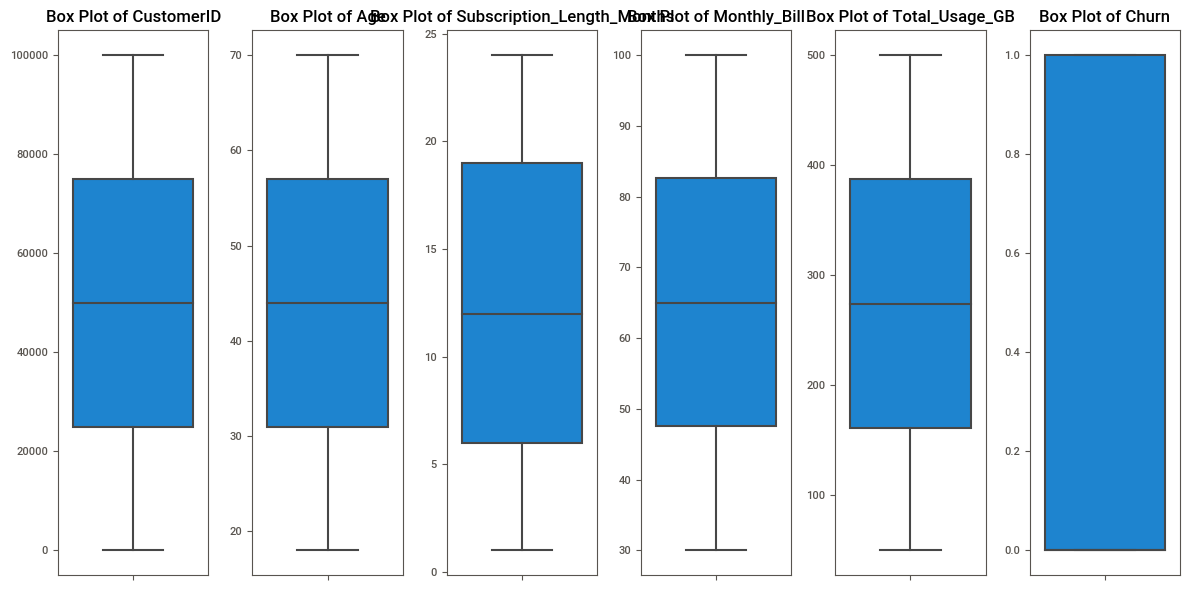

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('customer_churn_large_dataset.csv')

# Create a list of numeric column names (you may need to adjust this based on your dataset)
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Create box plots for each numeric column
plt.figure(figsize=(12, 6))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, len(numeric_columns), i)
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}')
    plt.ylabel('')
    
plt.tight_layout()
plt.show()

In [24]:
# Import necessary libraries
import pickle
from flask import Flask, request, jsonify

# Assuming you have already trained a model and assigned it to the 'model' variable

# Save the trained model to a file (model.pkl)
with open('model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Create a Flask web application
app = Flask(__name__)

# Define a route for model prediction
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the request
        data = request.get_json()
        
        # Make predictions using the loaded model
        prediction = model.predict([data['features']])[0]  # Adjust 'features' to your data structure
        
        # Return the prediction as JSON response
        return jsonify({'prediction': prediction})
    
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    # Start the Flask app
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\kundan Gupta\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [28]:
import pickle
from flask import Flask, request, jsonify

# Load the trained modelwith open('model.pkl', 'rb') as model_file:
with open('model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

app = Flask(__name__)

# Define a route for model prediction
@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from the request
        data = request.get_json()
        
        # Assuming your model expects features in the format 'features'
        features = data.get('features', None)
        
        if features is None:
            return jsonify({'error': 'Missing features in the request'})

        # Make predictions using the loaded model
        prediction = model.predict([features])[0]
        
        # Return the prediction as JSON response
        return jsonify({'prediction': prediction})
    
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    # Start the Flask app
    app.run(host='0.0.0.0', port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.29.182:5000
Press CTRL+C to quit
192.168.29.182 - - [25/Aug/2023 01:03:34] "GET / HTTP/1.1" 404 -


In [ ]:
import requests

# Define the URL for making predictions
url = 'http://192.168.29.182:5000/predict'  # Replace with your server's IP address

# Define the data you want to send for prediction
data = {
    'features': [1.0, 2.0, 3.0]  # Replace with your actual feature data
}

# Send a POST request to the /predict route
response = requests.post(url, json=data)

# Print the prediction result
if response.status_code == 200:
    result = response.json()
    print(f"Prediction: {result['prediction']}")
else:
    print(f"Error: {response.text}")
